# Multiple Linear Regression using `theano`

We'll now walk through using gradient descent to solve our multiple linear regression problem with `theano`. We'll begin by building up a computational graph, and then letting `theano` handle the differentiation for us. 

With automatic differentiation, we'll still have to specify the details of what derivatives to compute, but will not actually have to take any derivatives by hand. This feature will become invaluable as we move towards neural networks with hundreds of thousands of parameters. 

## Computational Graphs for Multiple Linear Regression 

As we code up our forward and backward propagation steps with `theano`, let's keep their visuals around as a reference: 

### Forward Propagation

<img src="https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/imgs/custom/mult_linear_comp_graph_condensed_forprop.png?raw=true" width=300\>

### Backward Propagation

<img src="https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/imgs/custom/mult_linear_comp_graph_condensed_backprop.png?raw=true" width=400\>

### Building a computational graph with `theano`

As mentioned above, the biggest difference between our `numpy` and `theano` solutions for multiple linear regression is that we'll be able to use the automatic differentiation that `theano` offers. We'll have to tell `theano` what quantity to take the derivative of, and the parameters that it should take the derivative with respect to, but after that it'll handle the rest. 

Let's dive in and see what that looks like...

In [1]:
import numpy as np
import theano.tensor as T
import theano
from datasets.general import gen_multiple_linear
from utils.plotting import plot_errors
%matplotlib inline

In [2]:
def get_theano_graph(): 
    learning_rate = 0.1
    # 1. Define placeholder matrices for inputs. 
    xs, ys = T.dmatrices('xs', 'ys') # returns one or more matrices of type `float64`
    # 2. Define randomly initialized floats for our betas. 
    betas = theano.shared(np.random.random(size=(4, 1)), name='betas')

    # 3. Define the equation that generates predictions. 
    yhats = T.dot(xs, betas)
    # 4. Define the equation that generates our errors. 
    es = 0.5 * (ys - yhats) ** 2
    # 5. Define the aggregate cost (mean of squared errors)
    E = es.mean()
    # 6. Take advantage of `theanos` automatic differentiation, and use the derivatives
    #    to perform the update step. 
    d_betas = T.grad(E, betas)
    updates = [(betas, betas - learning_rate * d_betas)]
    # 7. Define a function that we can feed inputs to, obtain outputs from, and 
    #    perform updates on our coefficients / train them. 
    train = theano.function(inputs=[xs, ys], outputs=[E, yhats], 
                            updates=updates)
    
    return train

Just as in our solution for simple linear regression, our `get_theano_graph` returns a `theano.function` object that performs one iteration of our gradient descent procedure. It performs both forward propagation (steps `1-5`) and backward propagation (step `6`), and in the end [generates a callable function](http://deeplearning.net/software/theano/library/compile/function.html#module-theano.compile.function) that we can later use to perform one iteration of our gradient descent procedure (step `7`). The only real difference from our solution for simple linear regression is that we have specified our coefficients as a vector (via the `betas` shared variable), rather than individually.  

We are again able to take advantage of the automatic differentiation that `theano` offers. In step `6`, we use `T.grad`, passing as the first argument the quantity to take the derivative of and as the second what to take the derivative with respect to. To do so, we have to take the mean of the squared-error and then differentiate that.  The `T.grad` function expects a scalar input, and mathematically it's the same as taking the average across the individual derivatives, since the derivative of a sum is equal to the sum of the individual derivatives. 

The callable function generated in step `7` takes inputs (via the `inputs` argument), runs them through the graph, and returns outputs (specified by the `outputs` argument). This function has the side effect of updating the values of each of the betas in our `betas` shared variable (specified by the `updates` argument), which is ultimately how we learn the values for our coefficients. 

It's worth noting that our `betas` variable is defined as a [shared variable](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables). This tells `theano` that it should **share** the values held in this variable across calls to the function generated in step `7`. As a result, `theano` uses the `betas` variable values from the previous call to our function as the `betas` variable values that it updates in the current call. This ensures that we are continuously updating our `betas` through each call to our function, and over time converging to their true values.

Now, we'll write some code that actually uses this function to learn the true values for our `betas` vector. 

Final Error: 1.5096430815122248e-21


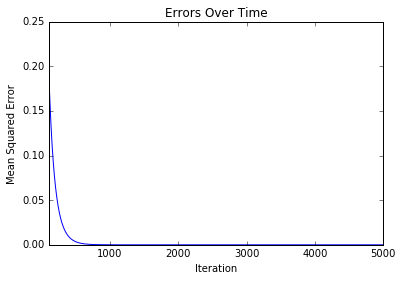

In [3]:
# Randomly generate our betas and number of observations, used to generate 
# fake data to fit. We should have a minimum of 4 obs, since we have 
# four coefficients. 
true_betas_array = np.random.randint(2, 10, size=4)
n_obs = np.random.randint(9500, 10500) 

# Generate the theano graph. This is in a function so that we can run this cell multiple times
# and obtain different randomly generated values for `betas`. 
theano_linear_graph = get_theano_graph()

# Generate the data that follows a linear relationship specified by `true_betas_array`.
xs, ys = gen_multiple_linear(true_betas_array, n_obs)

# Perform iterations (forward & backward prop.) over the theano graph
mean_squared_errors = []
for _ in range(5000): 
    mean_squared_error, yhats = theano_linear_graph(xs, ys)
    mean_squared_errors.append(mean_squared_error)
# Skip the first 100 values because it pulls the y-axis up quite a bit. 
plot_errors(mean_squared_errors, iterations=(100, 5000))
print("Final Error: {}".format(mean_squared_errors[-1]))

As we can see, this implementation is pretty similar to our implementation using `numpy`. The biggest difference is that we call our function `theano_linear_graph` at each iteration of our loop, as opposed to having the entire looping process defined within a function. This makes sense, though, given that our `theano_linear_graph` is defined to perform only **a single** iteration of our gradient descent procedure. 

Overall, we see that we can solve our linear regression problem using this computational graph that we defined with `theano`. Now, we'll code this up using `tensorflow`.